# Import Libraries

In [2]:
!pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.9 MB/s eta 0:00:00


In [27]:
import os
import json
import requests
from tqdm import tqdm

from PIL import Image

import torch
from transformers import CLIPProcessor, CLIPModel

# Load Data

In [4]:
os.mkdir("clip")
os.chdir("clip")

In [7]:
!wget "https://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip"

--2023-07-03 03:27:27--  https://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36745453 (35M) [application/zip]
Saving to: ‘caption_datasets.zip’

caption_datasets.zi 100%[===================>]  35.04M  11.9MB/s    in 2.9s    

2023-07-03 03:27:31 (11.9 MB/s) - ‘caption_datasets.zip’ saved [36745453/36745453]



In [8]:
!unzip "caption_datasets.zip"

Archive:  caption_datasets.zip
  inflating: dataset_coco.json       
  inflating: dataset_flickr30k.json  
  inflating: dataset_flickr8k.json   


In [19]:
with open('dataset_coco.json') as f:
  coco_dict = json.load(f)
  image_info = coco_dict['images'][:50]

In [20]:
def is_url_image(image_url):
   image_formats = ("image/png", "image/jpeg", "image/jpg")
   r = requests.head(image_url)
   if r.headers["content-type"] in image_formats:
      return True
   return False

In [21]:
image_exists = []

for image in tqdm(image_info):
  url_parts = image['filename'].split('_')

  url = "http://images.cocodataset.org/train2017" + "/" + url_parts[2]

  if is_url_image(url):
    image['url'] = url
    image_exists.append(image)

100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


In [22]:
print(len(image_exists))

44


# Create Model

In [23]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Create Search Space


In [34]:
image_embeds = []
text_embeds = []

for image in tqdm(image_exists):
  #create image embeddings
  img = Image.open(requests.get(image['url'], stream=True).raw)
  inputs = processor(images=img, return_tensors="pt")
  image_features = model.get_image_features(**inputs)

  #create text embeddings
  inputs = processor(text=[image['sentences'][0]['raw']], return_tensors="pt")
  text_features = model.get_text_features(**inputs)

  #add embeddings to data structure
  image_embeds.append(image_features)
  text_embeds.append(text_features)

100%|██████████| 44/44 [01:01<00:00,  1.41s/it]


In [35]:
img_embeds = torch.cat(image_embeds)
txt_embeds = torch.cat(text_embeds)

In [31]:
#img_embeds.shape

torch.Size([44, 512])

# Create Search Function

In [55]:
from torch.nn.functional import cosine_similarity

def search(query, criterion="text"):
  results = None
  if criterion == "text":
    #get text features
    inputs = processor(text=[query], return_tensors="pt")
    txt_feats = model.get_text_features(**inputs)
    #apply cossim to image embeds
    results = cosine_similarity(txt_feats, img_embeds)
    #get image
    image = image_info[torch.argmax(results)]
    img = Image.open(requests.get(image['url'], stream=True).raw)
    img.show()
  elif criterion == "image":
    #get image features
    img = Image.open(requests.get(query, stream=True).raw)
    inputs = processor(images=img, return_tensors="pt")
    img_feats = model.get_image_features(**inputs)
    #apply cossim to text embeds
    results = cosine_similarity(img_feats, txt_embeds)
    #get text
    text = image_info[torch.argmax(results)]
    txt = text['sentences'][0]['raw']
    print(txt)
  else:
    raise Exception("Invalid Criterion!")

  return image_info[torch.argmax(results)]

  #if results:
    #return

A man with a red helmet on a small moped on a dirt road. 


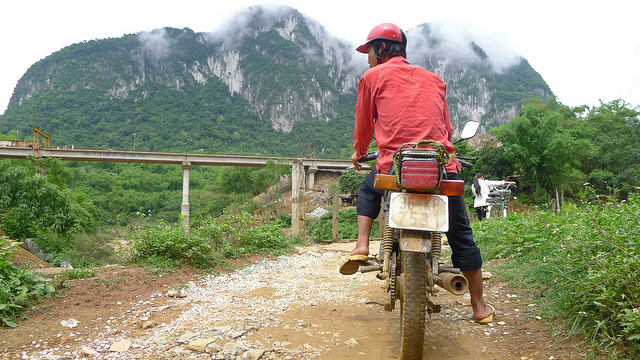

{'filepath': 'val2014', 'sentids': [770337, 771687, 772707, 776154, 781998], 'filename': 'COCO_val2014_000000391895.jpg', 'imgid': 0, 'split': 'test', 'sentences': [{'tokens': ['a', 'man', 'with', 'a', 'red', 'helmet', 'on', 'a', 'small', 'moped', 'on', 'a', 'dirt', 'road'], 'raw': 'A man with a red helmet on a small moped on a dirt road. ', 'imgid': 0, 'sentid': 770337}, {'tokens': ['man', 'riding', 'a', 'motor', 'bike', 'on', 'a', 'dirt', 'road', 'on', 'the', 'countryside'], 'raw': 'Man riding a motor bike on a dirt road on the countryside.', 'imgid': 0, 'sentid': 771687}, {'tokens': ['a', 'man', 'riding', 'on', 'the', 'back', 'of', 'a', 'motorcycle'], 'raw': 'A man riding on the back of a motorcycle.', 'imgid': 0, 'sentid': 772707}, {'tokens': ['a', 'dirt', 'path', 'with', 'a', 'young', 'person', 'on', 'a', 'motor', 'bike', 'rests', 'to', 'the', 'foreground', 'of', 'a', 'verdant', 'area', 'with', 'a', 'bridge', 'and', 'a', 'background', 'of', 'cloud', 'wreathed', 'mountains'], 'raw'

In [49]:
print(image_info[0]['sentences'][0]['raw'])
print(search('dirt road', criterion="text"))
#print(search(image_info[0]['sentences'][0]['raw'], criterion="text"))

In [56]:
print(search(image_info[0]['url'], "image"))

A man with a red helmet on a small moped on a dirt road. 
{'filepath': 'val2014', 'sentids': [770337, 771687, 772707, 776154, 781998], 'filename': 'COCO_val2014_000000391895.jpg', 'imgid': 0, 'split': 'test', 'sentences': [{'tokens': ['a', 'man', 'with', 'a', 'red', 'helmet', 'on', 'a', 'small', 'moped', 'on', 'a', 'dirt', 'road'], 'raw': 'A man with a red helmet on a small moped on a dirt road. ', 'imgid': 0, 'sentid': 770337}, {'tokens': ['man', 'riding', 'a', 'motor', 'bike', 'on', 'a', 'dirt', 'road', 'on', 'the', 'countryside'], 'raw': 'Man riding a motor bike on a dirt road on the countryside.', 'imgid': 0, 'sentid': 771687}, {'tokens': ['a', 'man', 'riding', 'on', 'the', 'back', 'of', 'a', 'motorcycle'], 'raw': 'A man riding on the back of a motorcycle.', 'imgid': 0, 'sentid': 772707}, {'tokens': ['a', 'dirt', 'path', 'with', 'a', 'young', 'person', 'on', 'a', 'motor', 'bike', 'rests', 'to', 'the', 'foreground', 'of', 'a', 'verdant', 'area', 'with', 'a', 'bridge', 'and', 'a', 'b